In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dateutil.relativedelta import *

## Load data and process

In [2]:
players = pd.read_csv("nhl_player_births.csv")
rosters = pd.read_csv("nhl_rosters.csv")
teams = pd.read_csv("nhl_teams.csv")

df = pd.merge(rosters, teams, left_on="team_code", right_on="team_code", how="left")
df = df.rename(columns={"full_name": "team_name"})

In [3]:
# season start year
df["season_start"] = pd.to_datetime([str(i)[:4] + "-10-01" for i in df["season"]])

# calculate age of player at season start
df["birth_date"] = pd.to_datetime(df["birth_date"])
df["age_season_start"] = [relativedelta(i,j).years for i,j in zip(df["season_start"], df["birth_date"]) ]

## Visualise

- Median age over time: season average + per team
- Broken axis [tutorial](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html)

In [24]:
# avg age by team
pivot = df.groupby(["team_name", "season"]).agg({"age_season_start":"median"})
pivot = pivot.unstack().transpose().reset_index()
pivot = pivot[pivot["season"]>19790000]
pivot = pivot.drop(columns="level_0").set_index("season")
pivot = pivot.stack().to_frame().reset_index().rename(columns={0:"mean_age"})
pivot["season_label"] = [str(i)[:4] + "/"+ str(i)[6:] for i in pivot["season"]]

# x position for plot
dict = {}
for i, season in enumerate(pivot["season"].unique()):
    dict[season] = i
pivot["x_pos"] = pivot["season"].map(dict)

# get avg age per season
total_avg = df.drop_duplicates(subset=["player_id", "season"], keep="first").reset_index(drop=True)
total_avg = total_avg.groupby(["season"]).agg({"age_season_start": "median"}).reset_index()
total_avg = total_avg[total_avg["season"]>19790000].reset_index(drop=True)

pivot

,season,team_name,mean_age,season_label,x_pos
0,19791980,Atlanta Flames,26.0,1979/80,0
1,19791980,Boston Bruins,27.0,1979/80,0
2,19791980,Buffalo Sabres,25.5,1979/80,0
3,19791980,Chicago Blackhawks,24.0,1979/80,0
4,19791980,Colorado Rockies,24.0,1979/80,0
...,...,...,...,...,...
1178,20232024,Toronto Maple Leafs,27.0,2023/24,43
1179,20232024,Vancouver Canucks,27.0,2023/24,43
1180,20232024,Vegas Golden Knights,26.0,2023/24,43
1181,20232024,Washington Capitals,29.0,2023/24,43


In [5]:
from matplotlib import font_manager
#font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
title_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Inter-Black.ttf')
subtitle_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Inter-Regular.ttf')

# set custom font
plt.rcParams["font.family"] = ["Ubuntu"]

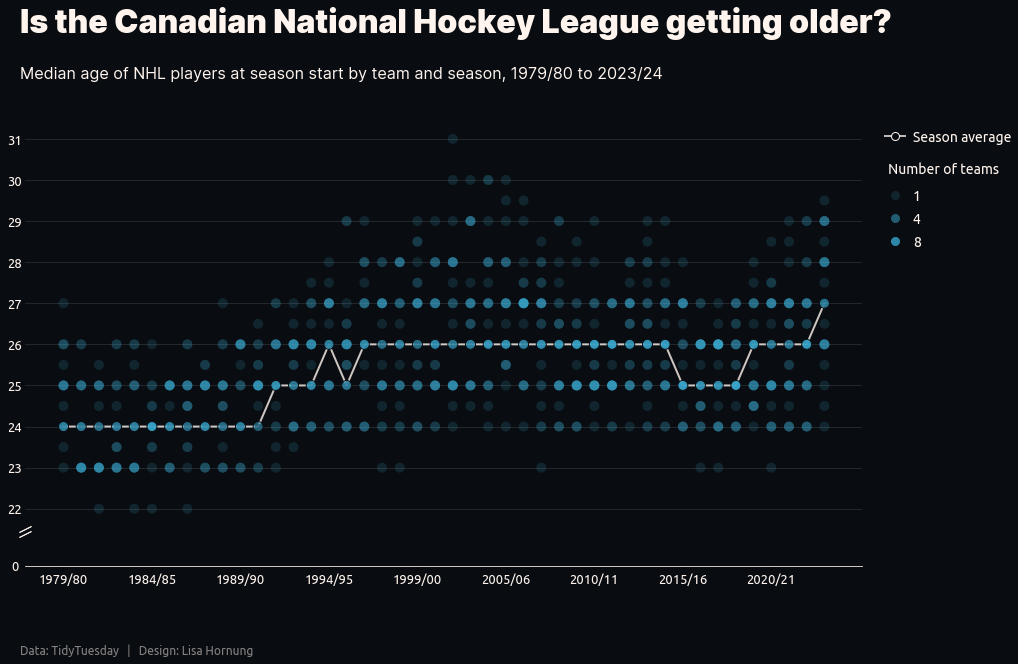

In [26]:
cols = {"dots": "#40B8E1", "bg": "#090C11", "line": "#FFF5EE", "text":"#FFF5EE"}

# layout -----------------------------------------------
fig = plt.figure(figsize=(15,8))
ax1 = plt.subplot2grid(shape=(12, 1), loc=(0, 0), rowspan=11)
ax2 = plt.subplot2grid(shape=(14, 1), loc=(13, 0))
fig.subplots_adjust(hspace=0.0)  # adjust space between axes
fig.set_facecolor(cols["bg"])

# plot data -----------------------------------------------
sns.stripplot(ax=ax1, data=pivot, x="season_label", y="mean_age", size=10, jitter=0,
              edgecolor="black",linewidth=0, color=cols["dots"], dodge=True, 
              alpha=0.15, zorder=2)
ax1.scatter( total_avg.index, total_avg["age_season_start"], zorder=4, linewidths=1,
                                    marker="o", s=100, facecolor="None", edgecolor=cols["bg"])
ax1.plot( total_avg.index, total_avg["age_season_start"],zorder=1, color=cols["line"],alpha=0.8, linewidth=2,
                                    marker="o", markersize=8, markerfacecolor=cols["bg"], markeredgecolor="None", markeredgewidth=1)

# Styling ---------------------------------------------
ax1.spines.bottom.set_visible(False)
for ax in [ax1, ax2]:
    ax.set_facecolor(cols["bg"])
    ax.spines['bottom'].set_color(cols["line"]) 
    for pos in ["top", "right", "left"]:
        ax.spines[pos].set_visible(False)

# configure xaxis and labels
ax1.axes.get_xaxis().set_label_text("")
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, color=cols["text"])
ax2.set_xlim(ax1.get_xlim())
custom_xlabels = [str(value) for value in pivot["season_label"].unique()[::5]]
ax2.set_xticks(np.arange(0, len(ax1.get_xticks()), 5), custom_xlabels, color=cols["text"])
plt.xticks(fontsize=13)

# configure yaxis
ax1.axes.get_yaxis().set_label_text("")
ax1.grid(visible=True, axis='y', zorder=1, color = "#EDEDED", alpha=0.15)
ax1.tick_params(axis='y', length = 0, labelsize=13, labelcolor=cols["text"])
ax1.set_ylim(ymin=21.5, ymax=31.2)
ax1.set_yticks(np.arange(22, 32, 1))
ax2.set_ylim(ymin=0, ymax=1)
ax2.set_yticks([0])
plt.yticks(fontsize=13, color=cols["text"])

# draw lines to indicate broken axis
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = {"marker":[(-1, -d), (1, d)], "markersize":12,
              "linestyle": "None",  "mew":1, "clip_on":False}
ax1.plot([0, 0], [0, 0], transform=ax1.transAxes, color=cols["line"], **kwargs)
ax2.plot([0, 0], [1, 1], transform=ax2.transAxes, color=cols["line"],**kwargs)

# Custom legend -----------------------------------------------
lgd = fig.add_axes([0.92, 0.68, 0.02, 0.2]) 
lgd.scatter(y=[1,2,2,2,2,3,3,3,3,3,3,3,3], x=[1,1,1,1,1,1,1,1,1,1,1,1,1], s=80, color=cols["dots"], alpha=0.15, linewidths=0)
lgd.plot([0,1,2],[-1.55,-1.55,-1.55],  markersize=8, marker="o", color=cols["line"], markerfacecolor=cols["bg"], 
         markeredgecolor=cols["line"], alpha=1, linewidth=1.5 ,clip_on=True)
lgd.invert_yaxis()
lgd.text(0.98,0.1,"Number of teams", fontsize=14, color=cols["text"])
lgd.text(1.05,1.05,"1", fontsize=14, va="center", color=cols["text"])
lgd.text(1.05,2.05,"4", fontsize=14, va="center", color=cols["text"])
lgd.text(1.05,3.05,"8", fontsize=14, va="center", color=cols["text"])
lgd.text(1.05,-1.5,"Season average", fontsize=14, va="center", color=cols["text"])
lgd.set_xlim(0.97, 1.03)
lgd.axis("off")

# Title and footer -----------------------------------------------
plt.figtext(0.12,1.05, "Is the Canadian National Hockey League getting older?", fontproperties = title_font, fontsize=32, color=cols["text"], ha="left")
plt.figtext(0.12,0.97, "Median age of NHL players at season start by team and season, 1979/80 to 2023/24", fontproperties = subtitle_font, fontsize=16, color=cols["text"], ha="left")
plt.figtext(0.12,-0.03, "Data: TidyTuesday   |   Design: Lisa Hornung", fontsize=12, color=cols["text"], ha="left", alpha=0.5)

# save
plt.savefig("nhl-avg-age-dotplot-v2.png", bbox_inches='tight', dpi=120, pad_inches=1)

plt.show()

In [ ]:
cols = {"dots": "#AFF3FE", "bg": "#090C11", "line": "white", "text":"white"}

# layout -----------------------------------------------
fig = plt.figure(figsize=(15,8))
ax1 = plt.subplot2grid(shape=(12, 1), loc=(0, 0), rowspan=11)
ax2 = plt.subplot2grid(shape=(14, 1), loc=(13, 0))
fig.subplots_adjust(hspace=0.0)  # adjust space between axes
fig.set_facecolor(cols["bg"])

# plot data -----------------------------------------------
sns.stripplot(ax=ax1, data=pivot, x="season_label", y="mean_age", size=10, jitter=0,
              edgecolor="black",linewidth=0, color=cols["dots"], dodge=True, 
              alpha=0.15, zorder=2)
ax1.scatter( total_avg.index, total_avg["age_season_start"], zorder=4, linewidths=1,
                                    marker="o", s=100, facecolor="None", edgecolor="black")
ax1.plot( total_avg.index, total_avg["age_season_start"],zorder=1, color=cols["line"],
                                    marker="o", markersize=8, markerfacecolor=cols["bg"], markeredgecolor="None", markeredgewidth=1)

# Styling ---------------------------------------------
# remove spines
ax1.spines.bottom.set_visible(False)
for pos in ["top", "right", "left"]:
    ax1.spines[pos].set_visible(False)
    ax2.spines[pos].set_visible(False)

ax1.set_facecolor(cols["bg"])
ax2.set_facecolor(cols["bg"])

# configure xaxis and labels
ax1.axes.get_xaxis().set_label_text("")
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, color=cols["text"])
ax2.set_xlim(ax1.get_xlim())
custom_xlabels = [str(value) for value in pivot["season_label"].unique()[::5]]
ax2.set_xticks(np.arange(0, len(ax1.get_xticks()), 5), custom_xlabels, color=cols["text"])
plt.xticks(fontsize=13)

# configure yaxis
ax1.axes.get_yaxis().set_label_text("")
ax1.grid(visible=True, axis='y', zorder=1, color = "#EDEDED", alpha=0.2)
ax1.tick_params(axis='y', length = 0, labelsize=13, color=cols["text"])
ax1.set_ylim(ymin=21.5, ymax=31.2)
ax1.set_yticks(np.arange(22, 32, 1))
ax2.set_ylim(ymin=0, ymax=1)
ax2.set_yticks([0])
plt.yticks(fontsize=13, color=cols["text"])

# draw lines to indicate broken axis
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = {"marker":[(-1, -d), (1, d)], "markersize":12,
              "linestyle": "None", "color":'k', "mec":'k', "mew":1, "clip_on":False}
ax1.plot([0, 0], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [1, 1], transform=ax2.transAxes, **kwargs)

# Custom legend -----------------------------------------------
lgd = fig.add_axes([0.92, 0.68, 0.02, 0.2]) 
lgd.scatter(y=[1,2,2,2,2,3,3,3,3,3,3,3,3], x=[1,1,1,1,1,1,1,1,1,1,1,1,1], s=80, color=cols["dots"], alpha=0.15, linewidths=0)
lgd.plot([0,1,2],[-1.55,-1.55,-1.55],  markersize=8, marker="o", color=cols["line"], markerfacecolor=cols["bg"], markeredgecolor=cols["line"], alpha=1, linewidth=1 ,clip_on=True)
lgd.invert_yaxis()
lgd.text(0.98,0.1,"Number of teams", fontsize=14)
lgd.text(1.05,1.05,"1", fontsize=14, va="center")
lgd.text(1.05,2.05,"4", fontsize=14, va="center")
lgd.text(1.05,3.05,"8", fontsize=14, va="center")
lgd.text(1.05,-1.5,"Season average", fontsize=14, va="center")
lgd.set_xlim(0.97, 1.03)
lgd.axis("off")

# Title and footer -----------------------------------------------
plt.figtext(0.12,1.0, "Are players in the Canadian National Hockey League getting older?", fontproperties = title_font, fontsize=22, color="black", ha="left")
plt.figtext(0.12,0.95, "Median age of NHL players by team and season", fontproperties = subtitle_font, fontsize=18, color="black", ha="left")
plt.figtext(0.12,0, "Data: TidyTuesday   |   Design: Lisa Hornung", fontsize=11, color="black", ha="left", alpha=0.75)

# save
#plt.savefig("nhl-avg-age-dotplot.png", bbox_inches='tight', dpi=120, pad_inches=1)

plt.show()

# Explore

In [ ]:
# year filter
year_filter = (df["season_start"] > pd.to_datetime("1989-10-01")) & ((df["season_start"] < pd.to_datetime("2023-10-01")))

In [ ]:
# age range per player
age_players = df.groupby(["player_id", "first_name", "last_name", "birth_country"]).agg({"age_season_start":["min", "max", "count"], "season": "min"})
age_players.columns = ['_'.join(col) for col in age_players.columns]
age_players["age_range"] = age_players["age_season_start_max"] - age_players["age_season_start_min"]


age_players = age_players.sort_values(by='age_range', ascending=False)
age_players = age_players.sort_values(by='age_season_start_max', ascending=False)
age_players.head(20)


In [ ]:
# avg age by season
pivot = df.groupby("season_start")["age_season_start"].max()
pivot.plot()

In [ ]:
pivot.set_index("season")["total"].plot()

### Idea: Top 15 oldest players

Stripes plot for top 15 players with 

- Guide on [how to recreate Warming Stripes in Matplotlib](https://matplotlib.org/matplotblog/posts/warming-stripes/)

In [365]:
# drop duplicate entries per player per season (ie. if they switched team at some point)
df_filtered = df.drop_duplicates(subset=["player_id", "season"], keep="first").reset_index(drop=True)

df_filtered = df_filtered.groupby(["player_id", "first_name", "last_name", "birth_country", "birth_date"]).agg(
    {"age_season_start": ["min", "max", lambda x: ','.join(map(str, x))],
     "team_code": ["nunique", np.unique],
     "season": ["min", "max","count"],
     })

# merge columns and rename
df_filtered.columns = ['_'.join(col) for col in df_filtered.columns]
df_filtered = df_filtered.rename(columns=lambda x: x.replace('_<lambda_0>', ''))

df_filtered["age_season_start"] = df_filtered["age_season_start"].str.split(",")
#df_filtered["team_code"] = df_filtered["team_code"].str.split(",")

df_filtered  = df_filtered.reset_index().set_index("player_id")
age_dummies = pd.get_dummies(df_filtered['age_season_start'].apply(pd.Series).stack()).sum(level=0)
df_filtered = pd.concat([df_filtered, age_dummies], axis=1)

df_filtered = df_filtered.sort_values(by="age_season_start_max", ascending=False)
df_filtered

C:\Users\LISA~1.HOR\AppData\Local\Temp/ipykernel_9236/2263873871.py:18: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  age_dummies = pd.get_dummies(df_filtered['age_season_start'].apply(pd.Series).stack()).sum(level=0)


,first_name,last_name,birth_country,birth_date,age_season_start_min,age_season_start_max,age_season_start,team_code_nunique,team_code_unique,season_min,...,39,40,41,42,43,44,45,46,47,51
player_id,,,,,,,,,,,,,,,,,,,,,
8448000,Gordie,Howe,CAN,1928-03-31,18,51,"[51, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2...",2,"[DET, HFD]",19461947,...,1,1,1,1,0,0,0,0,0,1
8446053,Chris,Chelios,USA,1962-01-25,21,47,"[47, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 2...",4,"[ATL, CHI, DET, MTL]",19831984,...,1,1,1,0,1,1,1,1,1,0
8450104,Moe,Roberts,USA,1905-12-13,19,45,"[25, 27, 19, 45]",3,"[BOS, CHI, NYA]",19251926,...,0,0,0,0,0,0,1,0,0,0
8448208,Jaromir,Jagr,CZE,1972-02-15,18,45,"[41, 42, 40, 18, 19, 20, 21, 22, 23, 24, 25, 2...",8,"[BOS, CGY, FLA, NJD, NYR, PHI, PIT, WSH]",19901991,...,1,1,1,1,1,1,1,0,0,0
8449835,Johnny,Bower,CAN,1924-11-08,28,44,"[33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 4...",2,"[NYR, TOR]",19531954,...,1,1,1,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8445299,Gord,Buttrey,CAN,1926-03-17,17,17,[17],1,[CHI],19431944,...,0,0,0,0,0,0,0,0,0,0
8448928,Jackie,Schmidt,CAN,1924-11-11,17,17,[17],1,[BOS],19421943,...,0,0,0,0,0,0,0,0,0,0
8448192,Eric,Prentice,CAN,1926-08-22,17,17,[17],1,[TOR],19431944,...,0,0,0,0,0,0,0,0,0,0


In [366]:
df_sorted = df.sort_values(by=["player_id", "season"])

df_player = df.groupby("player_id").agg({"age_season_start": lambda x: ','.join(map(str, x)),
                            "team_code":  lambda x: ','.join(x)})

df_player["team_code"] = df_player["team_code"].str.split(",")
df_player["age_season_start"] = df_player["age_season_start"].str.split(",")
df_player

,age_season_start,team_code
player_id,,
8444850,[24],[BOS]
8444851,[28],[TSP]
8444852,"[26, 28]","[DET, DET]"
8444853,"[24, 25, 25, 26]","[BOS, BOS, CHI, CHI]"
8444854,[22],[MTL]
...,...,...
8484166,[18],[CBJ]
8484254,[23],[VAN]
8484256,[23],[NSH]


In [367]:
age_changed_all = []
for _id in list(df_player.index):
    age_changed = []
    if len(df_player["team_code"][_id])>1:
        for i in range(1,len(df_player["team_code"][_id])):
            if df_player["team_code"][_id][i] != df_player["team_code"][_id][i-1]:
                age_changed.append(df_player["age_season_start"][_id][i])
    age_changed_all.append(age_changed)
    
df_player["aged_changed"] = age_changed_all
df_player.to_csv("test.csv")

In [368]:
df_filtered = pd.merge(df_filtered, df_player, left_index=True, right_index=True, how="left" )

ValueError: setting an array element with a sequence.

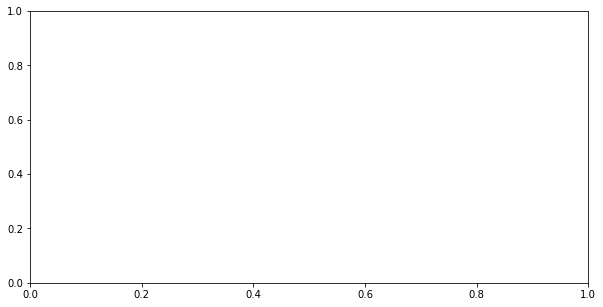

In [369]:
fig, ax = plt.subplots(figsize=(10,5))

data_for_plot = df_filtered[df_filtered.columns[14:].tolist()].replace(0, np.nan)
sns.heatmap(data_for_plot[:15], vmin=0, vmax=1, ax=ax, cbar=False)